<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/11_transformer_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Embeddings

Goal: Visualize clusters of articles in the German News Article Dataset

Embeddings are computed with
* FARM
* [Sentence-Transformers](https://www.sbert.net/examples/applications/computing-embeddings/README.html) (SBERT)
* Flair

and projected with t-SNE.

## Prerequisites

farm-haystack dependencies take a long time to install

In [1]:
%%time
# remove unused packages that will cause conflicts
!pip uninstall -q -y albumentations datascience nbclient
# ensure the right torch version
# farm-haystack 0.10.0 needs torch 1.8.1 and transformers 4.6.1
!pip install -q --upgrade torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1 torchaudio==0.8.1 >/dev/null
!pip install -q --upgrade farm-haystack pytest >/dev/null

# check installed version
!pip freeze | grep transformers
!pip freeze | grep farm
!pip freeze | grep torch
# transformers==4.6.1
# farm==0.8.0
# farm-haystack==0.10.0
# torch==1.8.1
# torchaudio==0.8.1
# torchtext==0.9.1
# torchvision==0.9.1

sentence-transformers==2.1.0
transformers==4.6.1
farm==0.8.0
farm-haystack==0.10.0
torch==1.8.1
torchaudio==0.8.1
torchsummary==1.5.1
torchtext==0.9.1
torchvision==0.9.1
CPU times: user 798 ms, sys: 160 ms, total: 957 ms
Wall time: 2min 19s


## Fetch Data

Download [10k German News Articles Dataset](https://tblock.github.io/10kGNAD/)

In [2]:
%env DIR=data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=data
2021-12-02 08:03:08 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "data/train.csv" [1]
2021-12-02 08:03:10 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "data/test.csv" [1]

2.7M Dec  2 08:03 test.csv
 24M Dec  2 08:03 train.csv


## Load Data

Using only the test dataset

In [3]:
import os
from pathlib import Path

data_dir = Path(os.getenv("DIR"))

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

In [4]:
import pandas as pd

def load_file(filepath: Path) -> pd.DataFrame:
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=['labels', 'text'])
    return f

In [5]:
test_df = load_file(data_dir / 'test.csv')
print(f"{test_df.shape[0]:,} articles")
display(test_df.head())

1,028 articles


,labels,text
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,Neues Video von Designern macht im Netz die Ru...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


## Compute Embeddings

### Farm-Haystack

In [64]:
import logging
import numpy as np
from farm.infer import Inferencer

logging.getLogger("farm.utils").setLevel(logging.WARN)
logging.getLogger("farm.infer").setLevel(logging.WARN)

# use GPU!
model = Inferencer.load("deepset/gbert-base", task_type="embeddings", extraction_strategy="cls_token", extraction_layer=-1, gpu=True, batch_size=32)

12/02/2021 08:47:25 - INFO - farm.modeling.language_model -   
12/02/2021 08:47:25 - INFO - farm.modeling.language_model -   LOADING MODEL
12/02/2021 08:47:25 - INFO - farm.modeling.language_model -   =============
12/02/2021 08:47:25 - INFO - farm.modeling.language_model -   Could not find deepset/gbert-base locally.
12/02/2021 08:47:25 - INFO - farm.modeling.language_model -   Looking on Transformers Model Hub (in local cache and online)...
Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Be

In [7]:
input = [{"text": i} for i in test_df.text]
input[:3]

[{'text': 'Die Gewerkschaft GPA-djp lanciert den "All-in-Rechner" und findet, dass die Vertragsform auf die Führungsebene beschränkt gehört. Wien – Die Gewerkschaft GPA-djp sieht Handlungsbedarf bei sogenannten All-in-Verträgen. Für mehr Transparenz haben die Gewerkschaft nun unter www.allinrechner.at ein Online-Werkzeug lanciert, das Arbeitnehmern mit solchen Verträgen helfen soll, sich einen Überblick zu verschaffen. Es geht darum, ob die Differenz zum Grundgehalt nicht womöglich eine zu geringe ist. Schließlich sei ein All-in-Gehalt oft nur auf den ersten Blick von Vorteil, gab GPA-djp-Chef Wolfgang Katzian (SPÖ) am Montag bei einer Pressekonferenz in Wien zu bedenken. Allzu oft sei bei der All-in-Entlohnung nur schwer nachvollziehbar, wie viele Überstunden und Mehrleistungen damit tatsächlich abgegolten werden. Ein erster guter Schritt aus gewerkschaftlicher Sicht ist Katzian zufolge zwar eine seit Ende Vorjahr gültige Gesetzesänderung, die besagt, dass das Grundgehalt bei All-in-V

In [65]:
%%time
embeddings = model.inference_from_dicts(dicts=input)

Inferencing Samples: 100%|██████████| 4/4 [00:00<00:00,  4.97 Batches/s]

(1028, 768)
CPU times: user 7.9 s, sys: 67.4 ms, total: 7.96 s
Wall time: 8.73 s


In [66]:
embeds = np.array([e["vec"] for e in embeddings])
print(embeds.shape)

(1028, 768)


In [ ]:
# !pip install faiss-gpu # restart
# !pip install tsnecuda

## Visualization of Embeddings

In [14]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

#### TSNE

In [16]:
%%time
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
np.set_printoptions(suppress=True)
tsne = tsne.fit_transform(embeds)
print(tsne.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1028, 2)
CPU times: user 8.97 s, sys: 199 ms, total: 9.17 s
Wall time: 8.99 s


In [52]:
def scatter(tsne, labels, title=None, figsize=(6,4)):
    le = LabelEncoder()
    labels_idx = le.fit_transform(labels)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)

    scatter = ax.scatter(tsne[:, 0], tsne[:, 1], c=labels_idx, cmap="Set1")
    ax.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_))
    fig.tight_layout()

In [42]:
# split data

exclude = ["Panorama", "Wirtschaft", "Etat"]

exclude_idx = test_df[lambda x: x.labels.isin(exclude)].index
include_idx = test_df[lambda x: ~x.labels.isin(exclude)].index

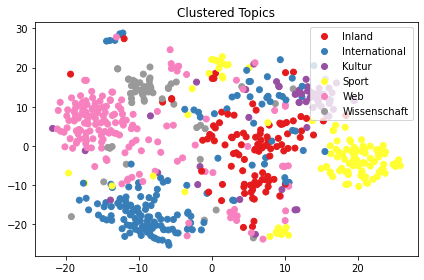

In [53]:
scatter(tsne[include_idx], test_df.labels[include_idx], title="Clustered Topics")

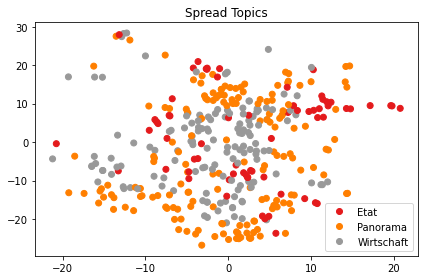

In [54]:
scatter(tsne[exclude_idx], test_df.labels[exclude_idx], title="Spread Topics")

#### Analyze mixed cluster in top left corner

In [19]:
selection = tsne_df[lambda x: ((x.x <-10.0) & (x.y >25.0))]

12/02/2021 08:12:16 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


In [20]:
test_df.iloc[selection.index.values]

,labels,text
51,International,Privater Besuch ohne Öffentlichkeit – Politike...
63,International,Explosion auf der Einkaufsstraße Istiklal Cadd...
197,International,Obama will das umstrittene Gefangenenlager noc...
253,Wirtschaft,Der Lebensmittelriese nimmt Maggi-Fertignudeln...
260,International,46 Prozent der Befragten würden derzeit für ei...
415,Panorama,Alle Religionen haben ihre hohen Feiertage – z...
436,International,Rund 100 Menschen verletzt – Politiker und Sic...
728,Inland,"Gemeindeergebnisse, Mandate und mögliche Koali..."
802,International,"Türkei verschärft Sicherheitsmaßnahmen, Opferz..."
821,Wirtschaft,Reaktion auf Schelte von EU und IWF. Der Vollt...


### Sentense Transformers

In [67]:
from sentence_transformers import SentenceTransformer

logging.getLogger("huggingface_hub.file_download").setLevel(logging.WARN)

# model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
model = SentenceTransformer('deepset/gbert-base')

12/02/2021 08:48:53 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: deepset/gbert-base


Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

12/02/2021 08:49:13 - WARNING - root -   No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/deepset_gbert-base. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/deepset_gbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertFor

In [68]:
embeddings_st = model.encode(test_df.text)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [69]:
embeddings_st.shape

(1028, 768)

In [71]:
%%time
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
np.set_printoptions(suppress=True)
tsne = tsne.fit_transform(embeddings_st)
print(tsne.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1028, 2)
CPU times: user 8.98 s, sys: 150 ms, total: 9.13 s
Wall time: 8.93 s


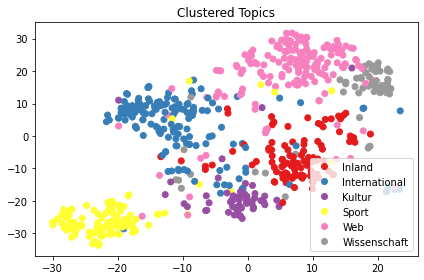

In [72]:
scatter(tsne[include_idx], test_df.labels[include_idx], title="Clustered Topics")

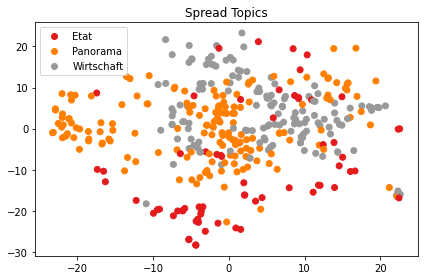

In [73]:
scatter(tsne[exclude_idx], test_df.labels[exclude_idx], title="Spread Topics")

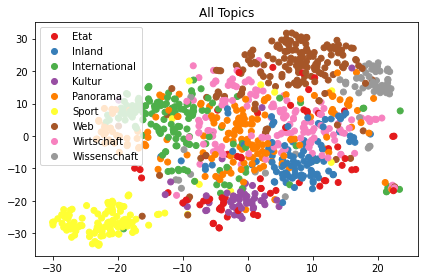

In [74]:
scatter(tsne, test_df.labels, title="All Topics")